# Quantum Approximate Optimization Algorithm

This program simulates QAOA on Max-Cut problem using qiskit. \
Author: Šimon Mařík \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

In first block of code, I am importing some libraris the code needs. Then we set the graph - edges is list of edges in graph, [x, y] means there exists an edge from vertix x to vertix y. Depth means how many laeyrs the circuit has - more layers = probable results become even more probable. Shots is number of shots used in the simulating. While optimizing the parametrs, it uses only 1/10 of the shots. Variable Seeds means how many times it tries to find best parametrs - to avoid local minima. Checkin is how many best solutions we check by brute force to find the real best solution.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import random

edges= [
#(0,1), (0,2), (0,3), (1,4), (2,5), (3,6), (4,5), (5,6)
[0, 7], [1, 2], [1, 3], [1, 4], [1, 7], [2, 4], [2, 5], [2, 7], [2, 8], [2, 9], [2, 10], [4, 6], [5, 6], [5, 7], [5, 8], [5, 9], [7, 9], [7, 10]
]
#edges is list of edges in graph, [x, y] means there is an edge from vertix x to vertix y
n = 11
#n is number of vertices
depth = 10
shots = 100000
seeds = 10
checkin = 100


There I define my functions - to funcion max_cut_value you input the graph (list of edges) and bitstring reprezenting some solution, and it returns score of this solution. To function exp_val you input number of occurenses of solution (and graph and bitstring) and it returns score multiplied by number of occurenses.

In [946]:
def exp_val(edges, string, count):
    score = max_cut_value(edges, string)
    val = (count * score)
    return val

def max_cut_value(edges, bitstring):
    """
    Spočítá počet hran, které jsou "řezané" pro daný bitstring.

    edges: seznam dvojic (i, j) reprezentujících hrany
    bitstring: řetězec '0101...' nebo seznam [0,1,0,...]

    Vrací počet řezaných hran.
    """
    # Pokud je bitstring řetězec, převedeme na seznam čísel
    if isinstance(bitstring, str):
        bits = [int(b) for b in bitstring]
    else:
        bits = bitstring
    
    cut_value = 0
    for i, j in edges:
        if bits[i] != bits[j]:
            cut_value += 1
    return cut_value


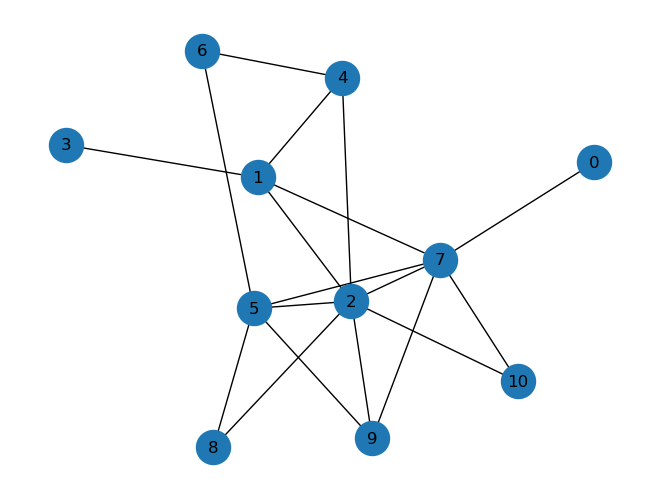

In [947]:
graph = rx.PyGraph()
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph.add_edges_from([(i, j, 1) for (i, j) in edges])
draw_graph(graph, node_size=600, with_labels=True)


There is the core function in this example. I define function f with input gamma, beta. It then runs the quantum circuit with these parametrs. In the end, it counts the mean value for best $checkin solutions and returns the mean value. Function minimize tries to optimalize the parametrs to get solution as large as possible (it is minimize, so we need minus sign). To avoid stucking in local minima, we run it multiple times with random starting parametrs.

In [948]:
def f(params):
    gamma,beta = params
    q = QuantumRegister(n, 'q')
    c = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(q, c)
    for i in range (n):
        qc.h(q[i])
    for i in range(depth):
        for (i, j) in edges:
            qc.rzz(2*gamma, q[i], q[j])
        for i in range (n):
            qc.rx(2*beta, q[i])
    for i in range (n):
        qc.measure(q[i], c[i])

    simulator = AerSimulator(shots=shots/10)
    job = simulator.run(qc)
    result = job.result()
    counts = result.get_counts()
    sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)[0:checkin]
    exval = 0
    for j in (sorted_counts):
        count = j[1]
        bitstring = j[0]
        exval += exp_val(edges, bitstring, count)
    exval = exval / (shots/10)
    return -exval

result = []
for i in range(seeds):
    result.append(minimize(f, [random.random(), random.random()], method='COBYLA'))
best = min(result, key=lambda r: r["fun"])
print(best)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.3092
       x: [-1.684e-01  1.535e-01]
    nfev: 35
   maxcv: 0.0


Now we program our circuit with best parametrs we were able to obtain.

Gamma: -0.16841524034638497, Beta: 0.15347633617969894


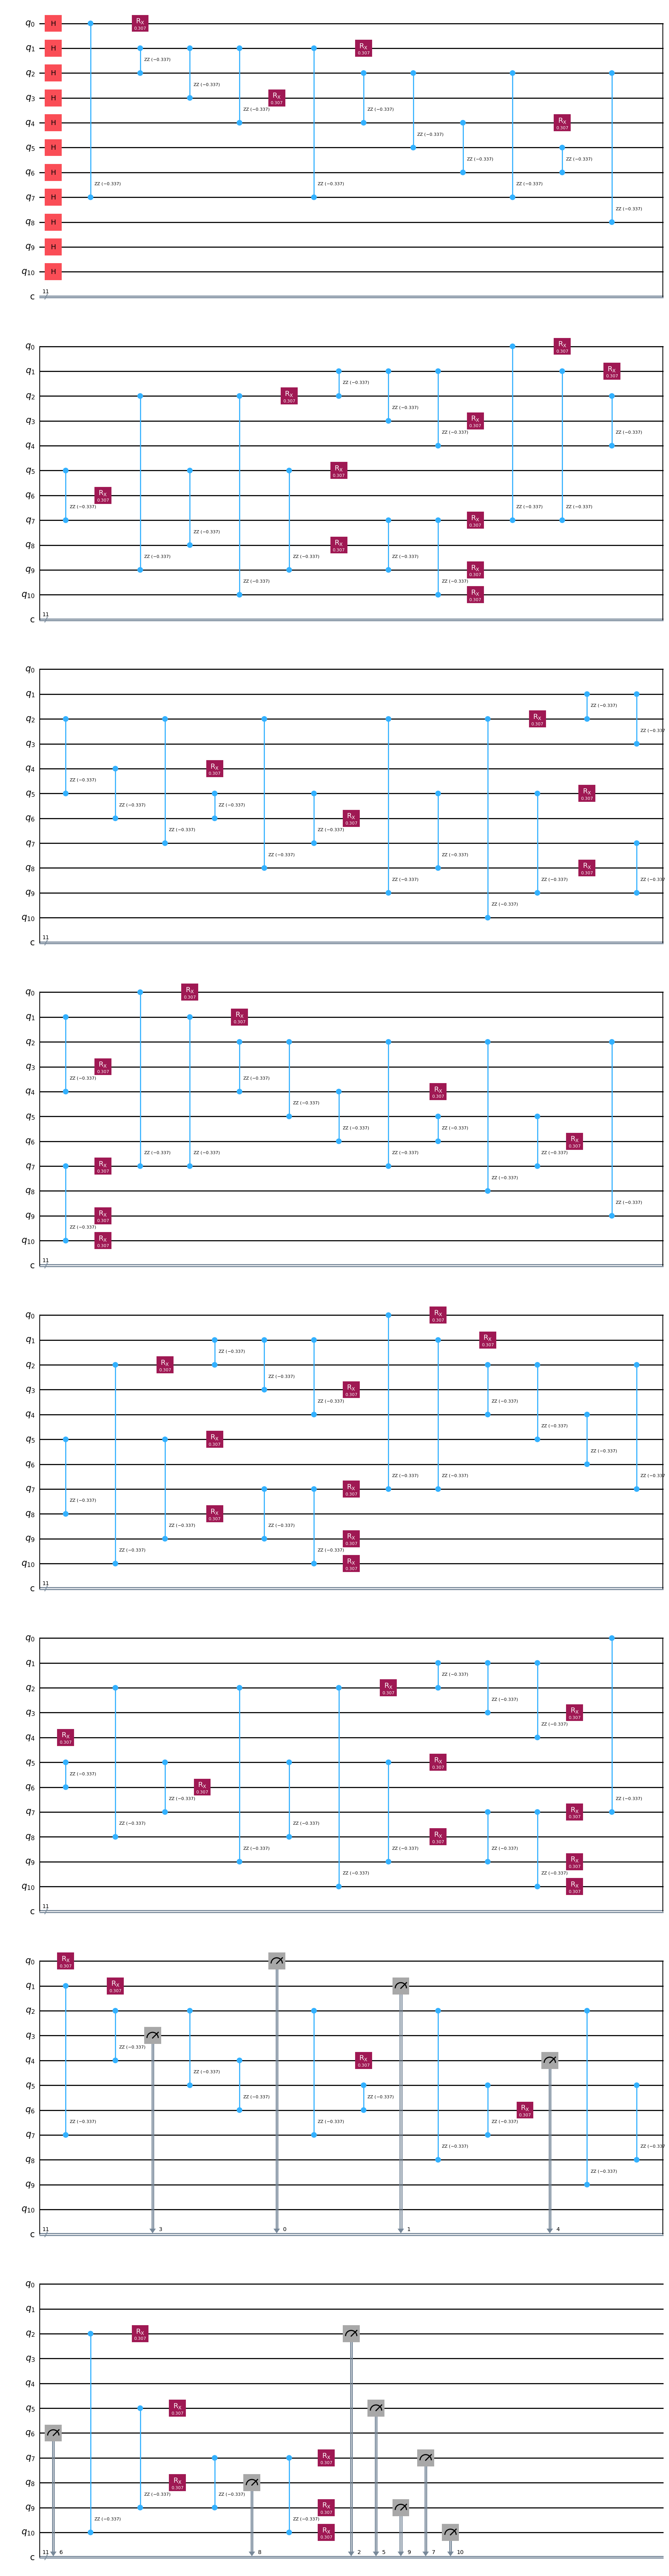

In [949]:

q = QuantumRegister(n, 'q')
c = ClassicalRegister(n, 'c')
qc = QuantumCircuit(q, c)
for i in range (n):
    qc.h(q[i])
for k in range(depth):
    gamma, beta = best["x"]
    for (i, j) in edges:
        qc.rzz(2*gamma, q[i], q[j])
    for i in range (n):
        qc.rx(2*beta, q[i])
for i in range (n):
    qc.measure(q[i], c[i])
print("Gamma: " + str(gamma) + ", Beta: " + str(beta))
qc.draw("mpl")

There we run it.

In [950]:
simulator = AerSimulator(shots=shots)
job = simulator.run(qc)
result = job.result()
counts = result.get_counts()

Now we print the most probable solutions + we check best $checkin solutions (by brute force) to find the truly best solution.

{'11011011001': 32, '00010101011': 3, '11111011000': 1202, '00101000110': 38, '00001010110': 28, '10110110000': 156, '10110101110': 4, '00010111100': 3392, '00101110111': 21, '10001011101': 18, '11110100011': 14, '00100010001': 2, '00001110000': 1, '00100001011': 3, '10001000011': 77, '01000001001': 4, '00000111101': 957, '00011000100': 580, '11100110011': 3353, '11010100100': 21, '00010011000': 123, '00111011101': 65, '01010111000': 73, '11010100101': 1, '11100110010': 279, '10111011110': 10, '01110011000': 980, '11110000011': 13, '00011100001': 5, '10100100111': 114, '11000011001': 16, '00011001100': 3323, '01100110010': 42, '01011010010': 54, '00010011110': 10, '11001001100': 17, '01111000111': 157, '10101111010': 4, '01001000111': 793, '11110011100': 33, '10111000111': 24, '01000100000': 1, '01100101110': 4, '10010100011': 61, '01011101110': 3, '11101000011': 3306, '00111110000': 22, '11001100011': 165, '00110011010': 91, '01101101011': 18, '11111110010': 17, '01010011111': 6, '110

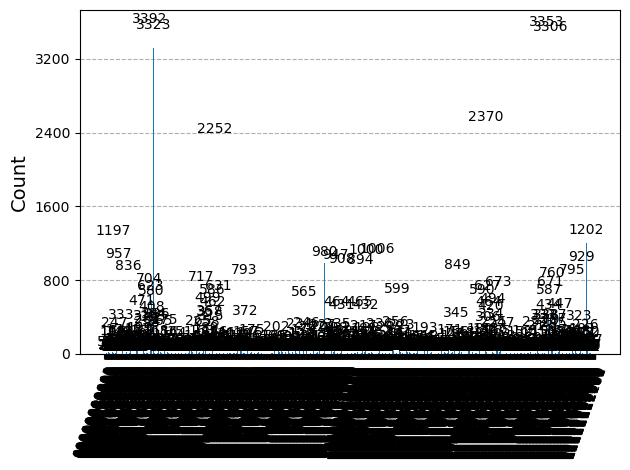

In [951]:
print(counts)
sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)[0:checkin]
print (sorted_counts)
best_count = min(sorted_counts, key=lambda r: -max_cut_value(edges, r[0]))
print("Most probable cut is " + str(max_cut_value(edges, sorted_counts[0][0])) + " edges")
print("Second probable cut is " + str(max_cut_value(edges, sorted_counts[1][0])) + " edges")
print("Third probable cut is " + str(max_cut_value(edges, sorted_counts[2][0])) + " edges")

print("Best cut found (in top "+ str(checkin) +") is " + str(max_cut_value(edges, best_count[0])) + " edges. (Probability: " + str(100*best_count[1]/shots) + "%)")
plot_histogram(counts)



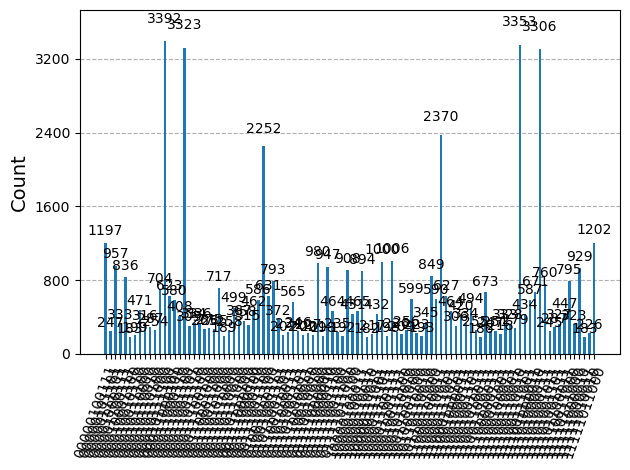

In [952]:
counts_dict = dict(sorted_counts)
plot_histogram(counts_dict)

Best found bitstring: 00110011000


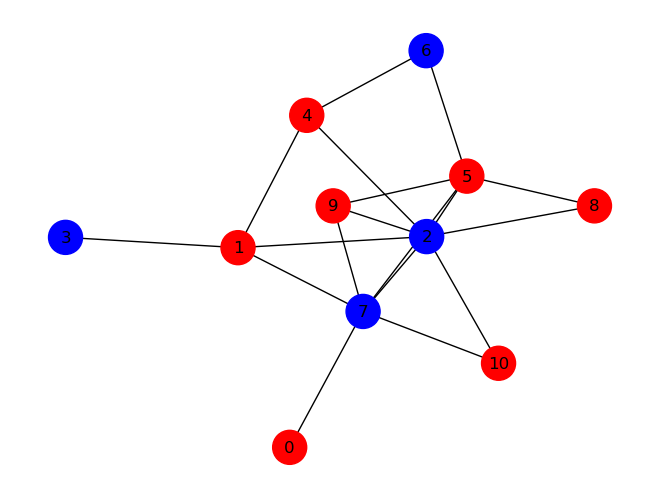

In [953]:
graph = rx.PyGraph()
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph.add_edges_from([(i, j, 1) for (i, j) in edges])
group1 = []
group2 = []
max = best_count[0]
for i in range(len(max)):
    if max[i] == "0":
        group1.append(i)
    else:
        group2.append(i)

node_colors = ['red' if node in group1 else 'blue' for node in range(n)]

print("Best found bitstring: " + max)

# vykreslení grafu
draw_graph(graph, node_size=600, with_labels=True, node_color=node_colors)